In [2]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

Using TensorFlow backend.


In [4]:
np.random.seed(2019)
tf.set_random_seed(2019)

In [5]:
train_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
print(train_df.shape)
train_df.head()

(3662, 2)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
def graham_method(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply edge enhancement using Laplacian filter
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    enhanced_edges = np.uint8(np.abs(laplacian))

    # Apply contrast enhancement using histogram equalization
    equalized = cv2.equalizeHist(gray)

    # Combine enhanced edges and equalized image
    enhanced_image = cv2.addWeighted(equalized, 0.7, enhanced_edges, 0.3, 0)

    # Apply noise reduction using Gaussian blur
    denoised_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)

    return denoised_image

def process_images(input_directory, output_directory):
    # Ensure output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # List all files in the input directory
    image_files = [f for f in os.listdir(input_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    for image_file in image_files:
        # Read the image
        input_path = os.path.join(input_directory, image_file)
        image = cv2.imread(input_path)

        # Apply Graham's method
        processed_image = graham_method(image)

        # Save the processed image to the output directory
        output_path = os.path.join(output_directory, image_file)
        cv2.imwrite(output_path, processed_image)

        print(f"Processed: {input_path} -> {output_path}")

input_directory = "/kaggle/input/aptos2019-blindness-detection/train_images"
output_directory = "/kaggle/working/preprocess"
process_images(input_directory, output_directory)

Processed: /kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png -> /kaggle/working/preprocess/ef476be214d4.png
Processed: /kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png -> /kaggle/working/preprocess/6dcde47060f9.png
Processed: /kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png -> /kaggle/working/preprocess/ec363f48867b.png
Processed: /kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png -> /kaggle/working/preprocess/17f6c7072f61.png
Processed: /kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png -> /kaggle/working/preprocess/b49b2fac2514.png
Processed: /kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png -> /kaggle/working/preprocess/af6166d57f13.png
Processed: /kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png -> /kaggle/working/preprocess/8d13c46e7d75.png
Processed: /kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

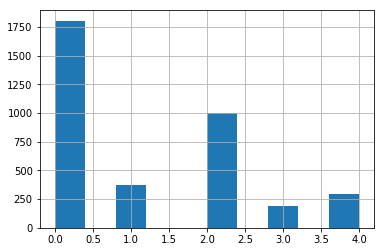

In [8]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

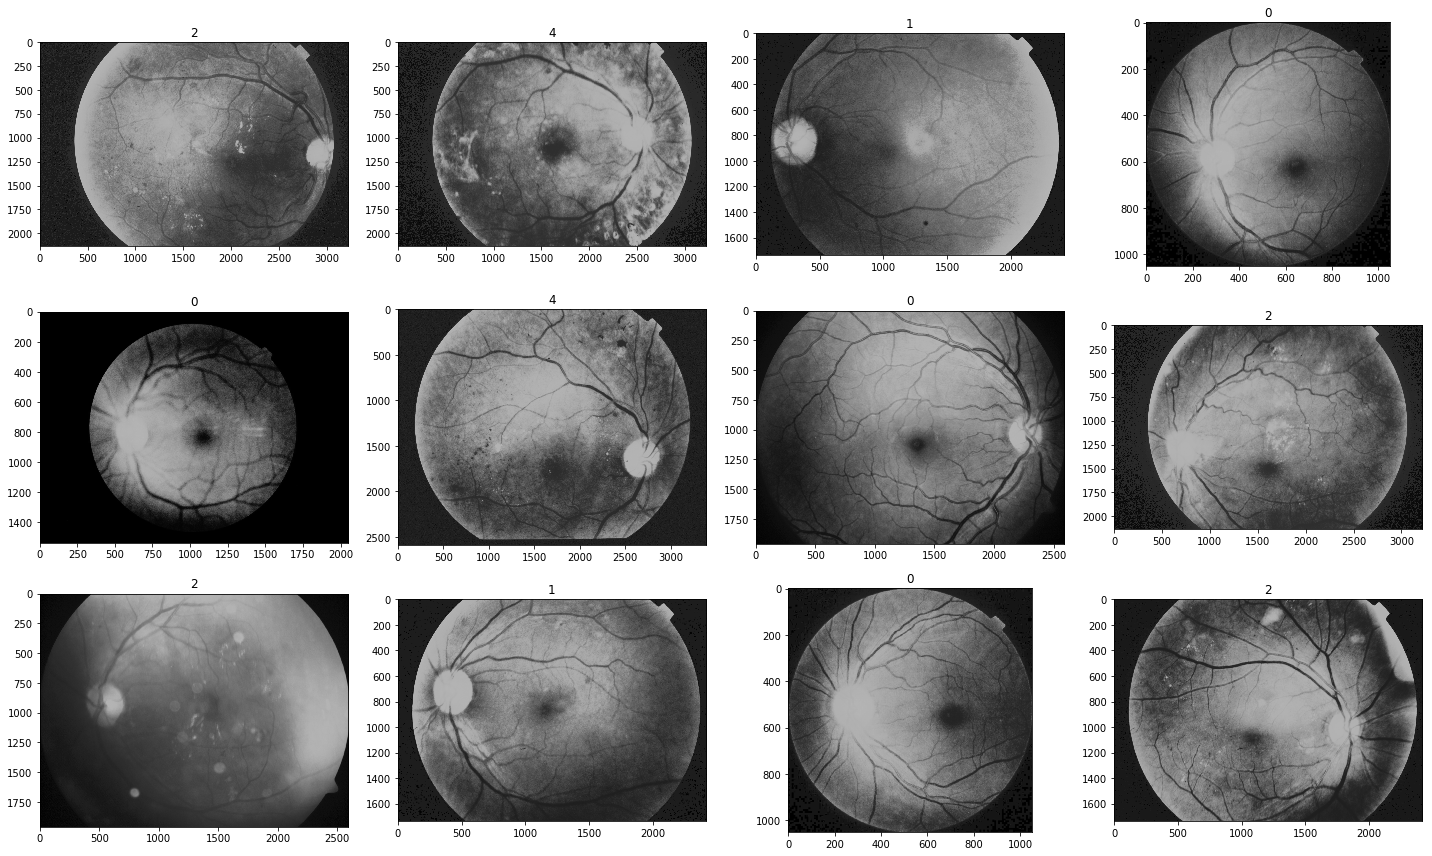

In [9]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'/kaggle/working/preprocess/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [10]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [14]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'/kaggle/working/preprocess/{image_id}.png'
    )

  0%|          | 0/3662 [00:00<?, ?it/s]


IndexError: too many indices for array

In [59]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)

(12522, 224, 224, 3)
(12522, 5)


In [60]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [6266  630 4477  236  913]
Multilabel version: [12522  6256  5626  1149   913]


In [61]:
y_train_multi = y_train_multi[:x_train.shape[0]]

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_train, y_train_multi, 
    test_size=0.2,
    random_state=2019
)

x_train_partial, x_val, y_train_partial, y_val = train_test_split(
    x_train_full, y_train_full, 
    test_size=0.1, 
    random_state=2019
)

In [62]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15, 
        fill_mode='constant',
        cval=0.,  
        horizontal_flip=True,  
        vertical_flip=True,  
    )

data_generator = create_datagen().flow(x_train_partial, y_train_partial, batch_size=BATCH_SIZE, seed=2019)

In [63]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

In [64]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [66]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [67]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [68]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

Epoch 1/20
392/391 [==============================] - 162s 412ms/step - loss: 0.3340 - acc: 0.8524 - val_loss: 0.2022 - val_acc: 0.9170
val_kappa: 0.7627
Validation Kappa has improved. Saving model.
Epoch 2/20
392/391 [==============================] - 125s 319ms/step - loss: 0.1944 - acc: 0.9208 - val_loss: 0.1663 - val_acc: 0.9321
val_kappa: 0.7953
Validation Kappa has improved. Saving model.
Epoch 3/20
392/391 [==============================] - 125s 319ms/step - loss: 0.1641 - acc: 0.9341 - val_loss: 0.1574 - val_acc: 0.9353
val_kappa: 0.8165
Validation Kappa has improved. Saving model.
Epoch 4/20
392/391 [==============================] - 125s 320ms/step - loss: 0.1393 - acc: 0.9453 - val_loss: 0.1729 - val_acc: 0.9385
val_kappa: 0.8324
Validation Kappa has improved. Saving model.
Epoch 5/20
392/391 [==============================] - 125s 318ms/step - loss: 0.1254 - acc: 0.9502 - val_loss: 0.1404 - val_acc: 0.9431
val_kappa: 0.8430
Validation Kappa has improved. Saving model.
Epoch

In [69]:
model.save('densenet.keras')

In [70]:
y_pred = model.predict(x_test) > 0.5
y_pred = y_pred.astype(int).sum(axis=1) - 1
y_pred[0]

2

In [73]:
y_true[0]

2

In [72]:
y_true = y_test.sum(axis=1) - 1
y_true[0]

2

In [74]:
print(y_pred.shape)
print(y_true.shape)

(2505,)
(2505,)


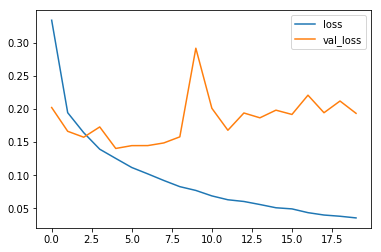

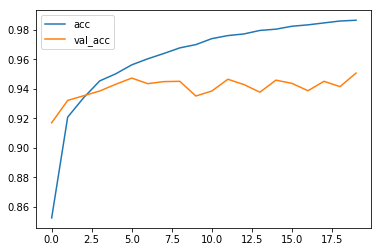

In [75]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

Confusion matrix:


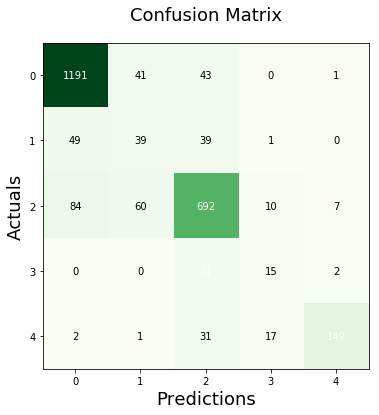

In [76]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_true, y_pred) 
print('Confusion matrix:')
 
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [77]:
accuracy = accuracy_score(y_true, y_pred) 
print('\nAccuracy : ', accuracy)


Accuracy :  0.8327345309381238


In [78]:
macro_precision = precision_score(y_true, y_pred, average = 'macro') 
micro_precision = precision_score(y_true, y_pred, average = 'micro') 
weighted_precision = precision_score(y_true, y_pred, average = 'weighted') 

print('Macro Precision : ', macro_precision)
print('Micro Precision : ', micro_precision)
print('Weighted Precision : ', weighted_precision)

Macro Precision :  0.6576962227286576
Micro Precision :  0.8327345309381238
Weighted Precision :  0.8350227916510755


In [79]:
macro_recall = recall_score(y_true, y_pred, average = 'macro') 
micro_recall = recall_score(y_true, y_pred, average = 'micro') 
weighted_recall = recall_score(y_true, y_pred, average = 'weighted') 

print('Macro recall : ', macro_recall)
print('Micro recall : ', micro_recall)
print('Weighted recall : ', weighted_recall)

Macro recall :  0.6213654952371678
Micro recall :  0.8327345309381238
Weighted recall :  0.8327345309381238


In [80]:
macro_f1 = f1_score(y_true, y_pred, average = 'macro') 
micro_f1 = f1_score(y_true, y_pred, average = 'micro') 
weighted_f1 = f1_score(y_true, y_pred, average = 'weighted') 

print('Macro f1 : ', macro_f1)
print('Micro f1 : ', micro_f1)
print('Weighted f1 : ', weighted_f1)

Macro f1 :  0.6369172299071546
Micro f1 :  0.8327345309381238
Weighted f1 :  0.8327484859427567
